In [8]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from torch.nn.parallel.scatter_gather import scatter_kwargs

# Read the CSV file
df = pd.read_csv('auto-mpg.csv')

# Convert '?' to NaN (missing values)
df['horsepower'] = df['horsepower'].replace('?', np.nan)

# Convert to float type
df['horsepower'] = df['horsepower'].astype(float)

# Now we need to decide how to handle the missing values
# Let's use the median, as it's less sensitive to outliers than the mean
horsepower_median = df['horsepower'].median()
df['horsepower'] = df['horsepower'].fillna(horsepower_median)

# Now we can prepare our X and y variables
X = df['horsepower'].values
y = df['mpg'].values

X_mean = X.mean()
X_centered = X - X_mean


# Create the linear regression model
with pm.Model() as model_g:
    # Priors for unknown model parameters
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    
    # Expected value of outcome
    mu = pm.Deterministic('mu', alpha_tmp + beta * X_centered.reshape(-1))
    
    alpha = pm.Deterministic('alpha', alpha_tmp - beta * X_mean)
    
    # Likelihood (sampling distribution) of observations
    y_pred = pm.Normal('y_pred', mu=mu, sigma=epsilon, observed=y)
    
    # Inference
    idata_g = pm.sample(2000, tune=2000, return_inferencedata=True)
    


KeyboardInterrupt



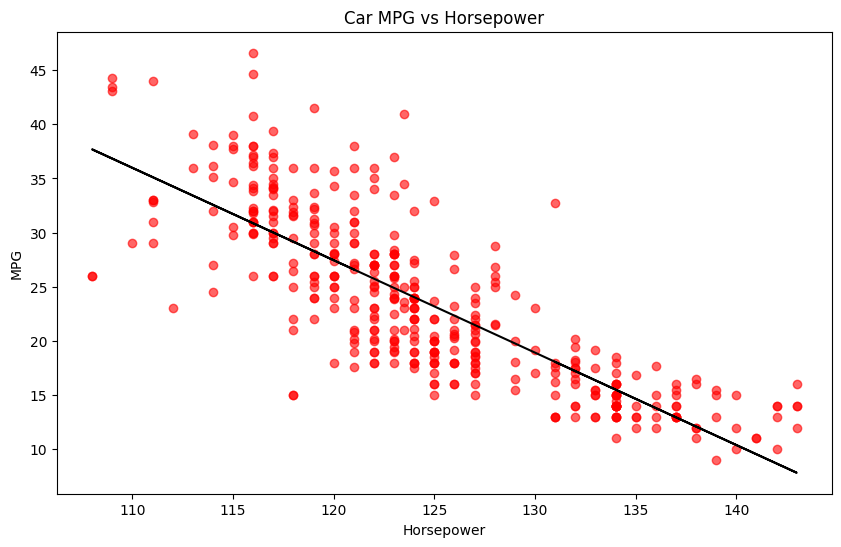

In [3]:
# plot the line and the data
# Add to the graph the 95% HDI for the line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, c='r', alpha=0.6)
plt.xlabel('Horsepower')
plt.ylabel('MPG')
plt.title('Car MPG vs Horsepower')
plt.plot(X, idata_g.posterior['alpha'].mean().item() + idata_g.posterior['beta'].mean().item() * X, c='k')

# Add to the graph 

<Axes: xlabel='alpha', ylabel='beta'>

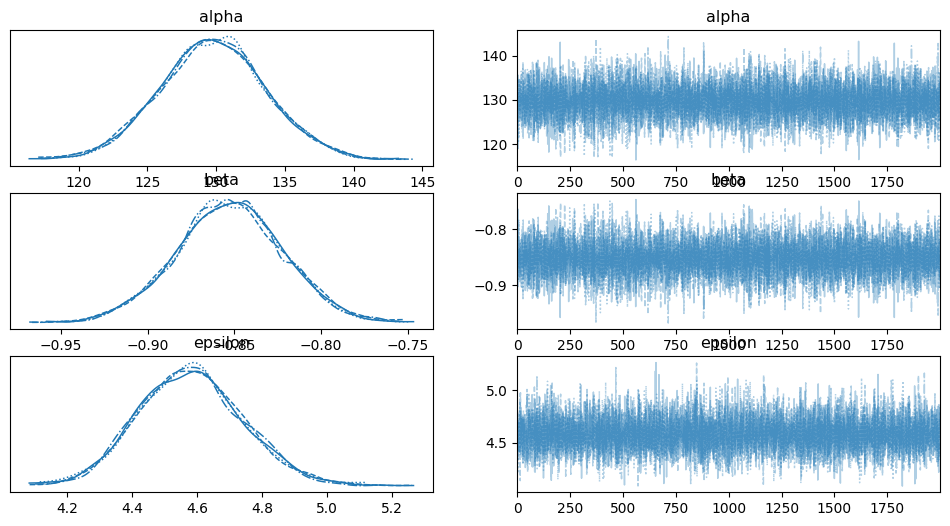

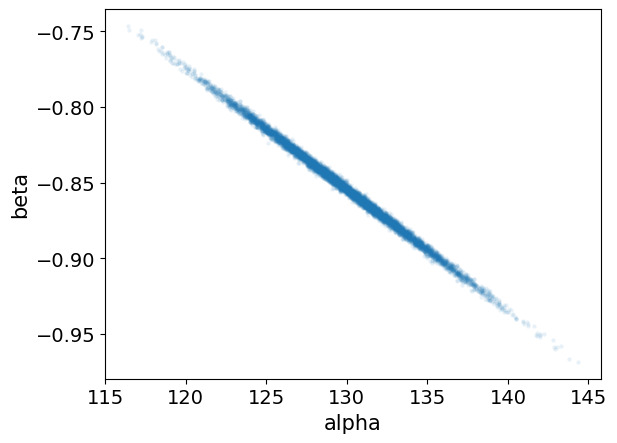

In [4]:
from arviz import plot_trace
import arviz as az
from arviz import plot_pair

az.plot_trace(idata_g, var_names=['alpha', 'beta', 'epsilon'])
az.plot_pair(idata_g, var_names=['alpha', 'beta'], scatter_kwargs={'alpha': 0.1})

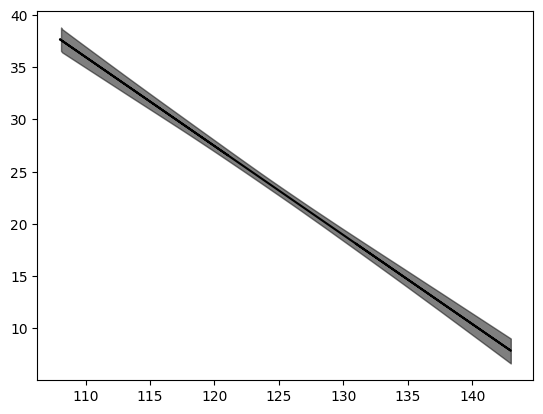

In [5]:
from arviz import plot_hdi

plt.plot(X, idata_g.posterior['alpha'].mean().item() + idata_g.posterior['beta'].mean().item() * X, c='k')

sig = az.plot_hdi(X, idata_g.posterior['mu'], hdi_prob=0.95, color='k')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_tmp, beta, epsilon, v]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 40 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


KeyError: "No variable named (slice(None, None, None), 0). Variables on the dataset include ['mu', 'mu_dim_0', 'hdi']\nHint: use a list to select multiple variables, for example `ds[[slice(None, None, None), 0]]`"

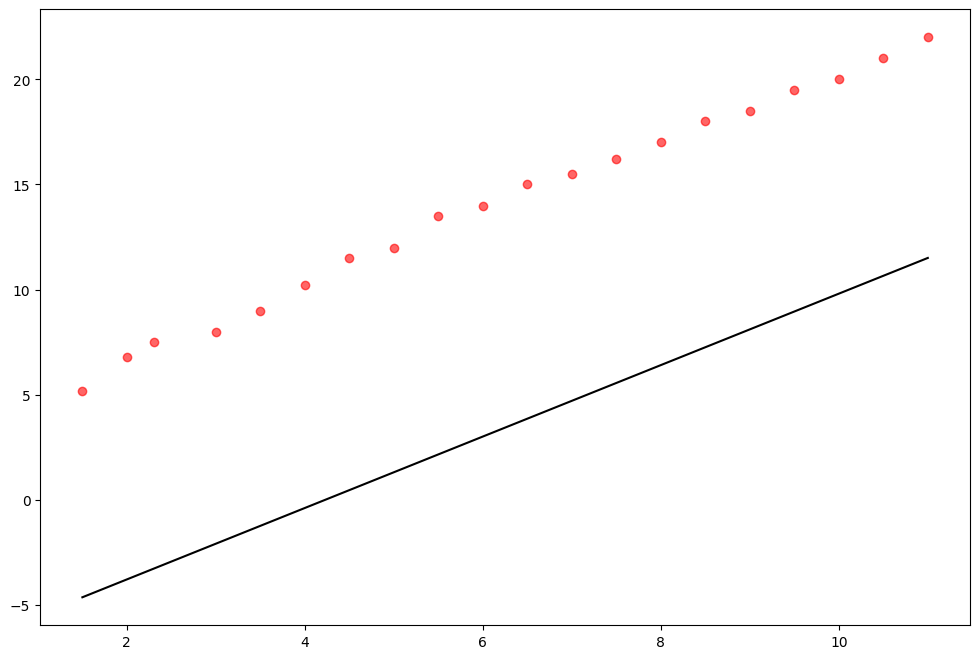

In [19]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

# Your data and model setup remains the same up until sampling
X = np.array([1.5, 2.0, 2.3, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11])
y = np.array([5.2, 6.8, 7.5, 8.0, 9.0, 10.2, 11.5, 12.0, 13.5, 14.0, 15.0, 15.5, 16.2, 17.0, 18.0, 18.5, 19.5, 20.0, 21.0, 22.0])

X_mean = X.mean()
X_centered = X - X_mean

with pm.Model() as model_g:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    v = pm.Exponential('v', 1/30)
    
    mu = pm.Deterministic('mu', alpha_tmp + beta * X_centered.reshape(-1))
    alpha = pm.Deterministic('alpha', alpha_tmp - beta * X_mean)
    
    y_pred = pm.StudentT('y_pred', mu=mu, sigma=epsilon, nu=v, observed=y)
    
    idata_g = pm.sample(2000, tune=2000, return_inferencedata=True)

# Create predictions including observation noise
posterior = idata_g.posterior
n_samples = len(posterior.alpha.values.flatten())
y_pred_samples = np.zeros((n_samples, len(X)))

# Generate samples for each posterior draw
for i in range(n_samples):
    mean_pred = (posterior.alpha.values.flatten()[i] + 
                posterior.beta.values.flatten()[i] * (X - X_mean))
    
    # Generate t-distributed noise
    t_samples = np.random.standard_t(
        df=posterior.v.values.flatten()[i],
        size=len(X)
    )
    y_pred_samples[i] = mean_pred + posterior.epsilon.values.flatten()[i] * t_samples

# Plot everything
plt.figure(figsize=(12, 8))

# Scatter plot of data
plt.scatter(X, y, c='red', alpha=0.6, label='Observed Data')

# Mean regression line
mean_line = posterior.alpha.mean().values + posterior.beta.mean().values * (X - X_mean)
plt.plot(X, mean_line, 'k-', label='Mean Regression Line')

# Plot HDI for the mean (mu)
hdi_mu = az.hdi(posterior.mu)
plt.fill_between(X, hdi_mu[:,0], hdi_mu[:,1], 
                color='gray', alpha=0.2, 
                label='95% HDI for Mean')

# Plot HDI for predicted y-values
hdi_y = az.hdi(y_pred_samples)
plt.fill_between(X, hdi_y[:,0], hdi_y[:,1], 
                color='blue', alpha=0.2,
                label='95% HDI for Predictions')

plt.xlabel('X')
plt.ylabel('y')
plt.title('Regression with Mean HDI and Prediction HDI')
plt.legend()
plt.show()

Mean predictions: [-5.01890762e+04 -6.83414560e+03  8.64781800e+04 -2.28597202e+06
 -2.88033712e+02]


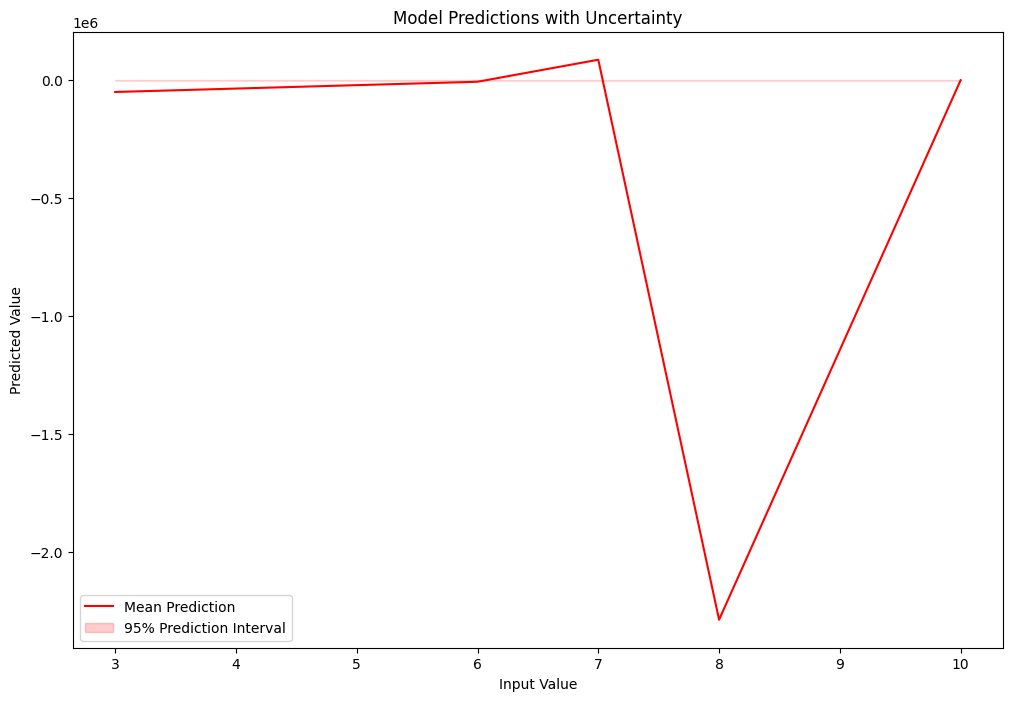

[-5.01890762e+04 -6.83414560e+03  8.64781800e+04 -2.28597202e+06
 -2.88033712e+02]


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def make_predictions(X_new, idata, X_mean, plot=True):
    """
    Generate predictions with uncertainty intervals using a trained PyMC model
    
    Parameters:
    X_new: array-like, the new input values to predict for
    idata: arviz.InferenceData, contains the posterior samples from PyMC
    X_mean: float, the mean used to center the training data
    plot: boolean, whether to create a visualization
    
    Returns:
    dict containing:
        - mean_predictions: array of mean predictions
        - prediction_intervals: 95% prediction intervals
        - samples: all prediction samples if needed for further analysis
    """
    # Center the new data using training data mean
    X_new_centered = X_new - X_mean
    
    # Extract posterior samples
    posterior = idata.posterior
    alpha_samples = posterior.alpha.values.flatten()
    beta_samples = posterior.beta.values.flatten()
    epsilon_samples = posterior.epsilon.values.flatten()
    v_samples = posterior.v.values.flatten()
    
    # Initialize array for predictions
    n_samples = len(alpha_samples)
    y_pred_samples = np.zeros((n_samples, len(X_new)))
    
    # Generate predictions for each posterior sample
    for i in range(n_samples):
        # Calculate mean prediction
        mean_pred = alpha_samples[i] + beta_samples[i] * X_new_centered
        
        # Generate standard t samples and transform them
        t_samples = np.random.standard_t(df=v_samples[i], size=len(X_new))
        # Transform to get the desired location and scale
        y_pred_samples[i] = mean_pred + epsilon_samples[i] * t_samples
    
    # Calculate summary statistics
    y_pred_mean = np.mean(y_pred_samples, axis=0)
    prediction_intervals = np.percentile(y_pred_samples, [2.5, 97.5], axis=0)
    
    print(f'Mean predictions: {y_pred_mean}')
    
    if plot:
        plt.figure(figsize=(12, 8))
        # Plot mean prediction line
        plt.plot(X_new, y_pred_mean, color='red', label='Mean Prediction')
        # Plot prediction intervals
        plt.fill_between(
            X_new, 
            prediction_intervals[0], 
            prediction_intervals[1],
            color='red', 
            alpha=0.2,
            label='95% Prediction Interval'
        )
        plt.xlabel('Input Value')
        plt.ylabel('Predicted Value')
        plt.title('Model Predictions with Uncertainty')
        plt.legend()
        plt.show()
    
    return {
        'mean_predictions': y_pred_mean,
        'prediction_intervals': prediction_intervals,
        'samples': y_pred_samples
    }

# Example usage:
X_new = np.array([3,6,7,8,10])
predictions = make_predictions(X_new, idata_g, X_mean)

print(predictions['mean_predictions'])

In [15]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from torch.nn.parallel.scatter_gather import scatter_kwargs

# Read the CSV file
# Set random seed for reproducibility
np.random.seed(42)

# Generate x values from 0 to 20
X = np.linspace(0, 20, 100)

# Create linear relationship (y = 2x + 1) with noise
slope = 2
intercept = 1
noise = np.random.normal(0, 1, 100)  # Gaussian noise with mean 0 and std 1
y = slope * X + intercept + noise

X_mean = X.mean()
X_centered = X - X_mean


# Create the linear regression model
with pm.Model() as model_g:
    # Priors for unknown model parameters
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    
    # Expected value of outcome
    mu = pm.Deterministic('mu', alpha_tmp + beta * X_centered.reshape(-1))
    
    alpha = pm.Deterministic('alpha', alpha_tmp - beta * X_mean)
    
    # Likelihood (sampling distribution) of observations
    y_pred = pm.Normal('y_pred', mu=mu, sigma=epsilon, observed=y)
    
    # Inference
    idata_g = pm.sample(2000, tune=2000, return_inferencedata=True)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_tmp, beta, epsilon]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 33 seconds.


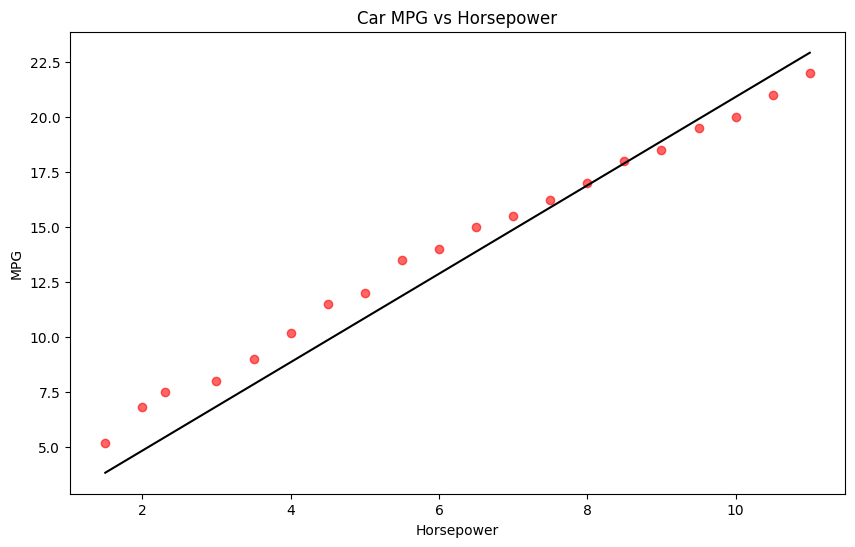

In [17]:
# plot the line and the data
# Add to the graph the 95% HDI for the line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, c='r', alpha=0.6)
plt.xlabel('Horsepower')
plt.ylabel('MPG')
plt.title('Car MPG vs Horsepower')
plt.plot(X, idata_g.posterior['alpha'].mean().item() + idata_g.posterior['beta'].mean().item() * X, c='k')

# Add to the graph 

<Axes: xlabel='alpha', ylabel='beta'>

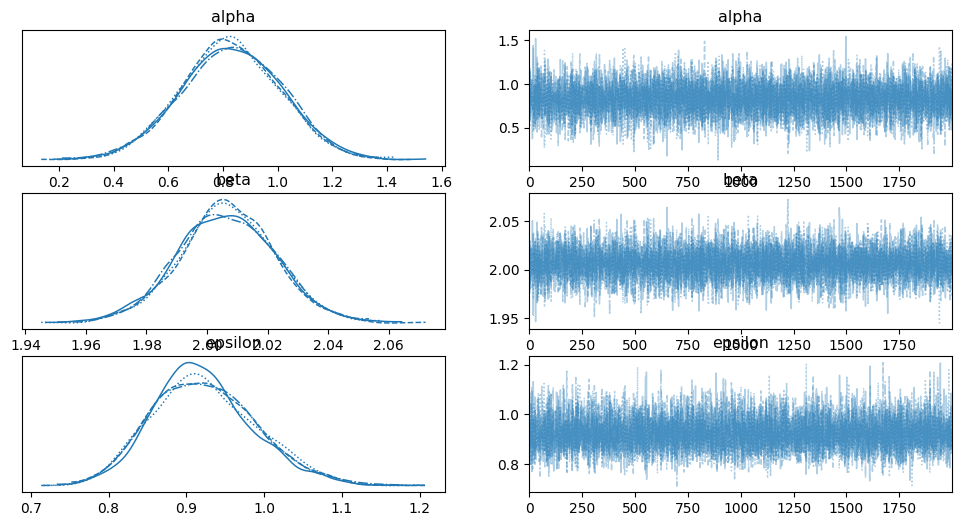

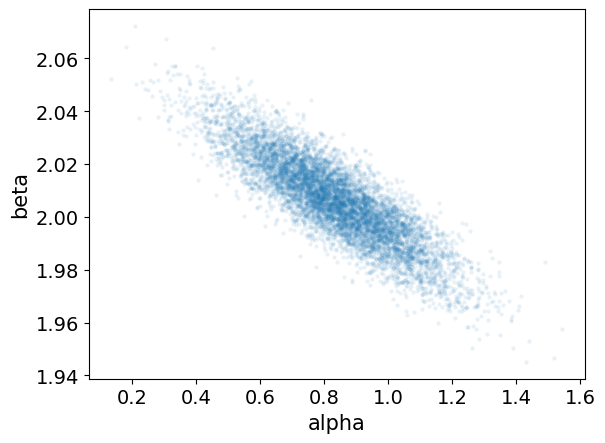

In [18]:
from arviz import plot_trace
import arviz as az
from arviz import plot_pair

az.plot_trace(idata_g, var_names=['alpha', 'beta', 'epsilon'])
az.plot_pair(idata_g, var_names=['alpha', 'beta'], scatter_kwargs={'alpha': 0.1})